<a href="https://colab.research.google.com/github/kaimani/AISC2007/blob/main/Maxwell_AISC2007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question 1

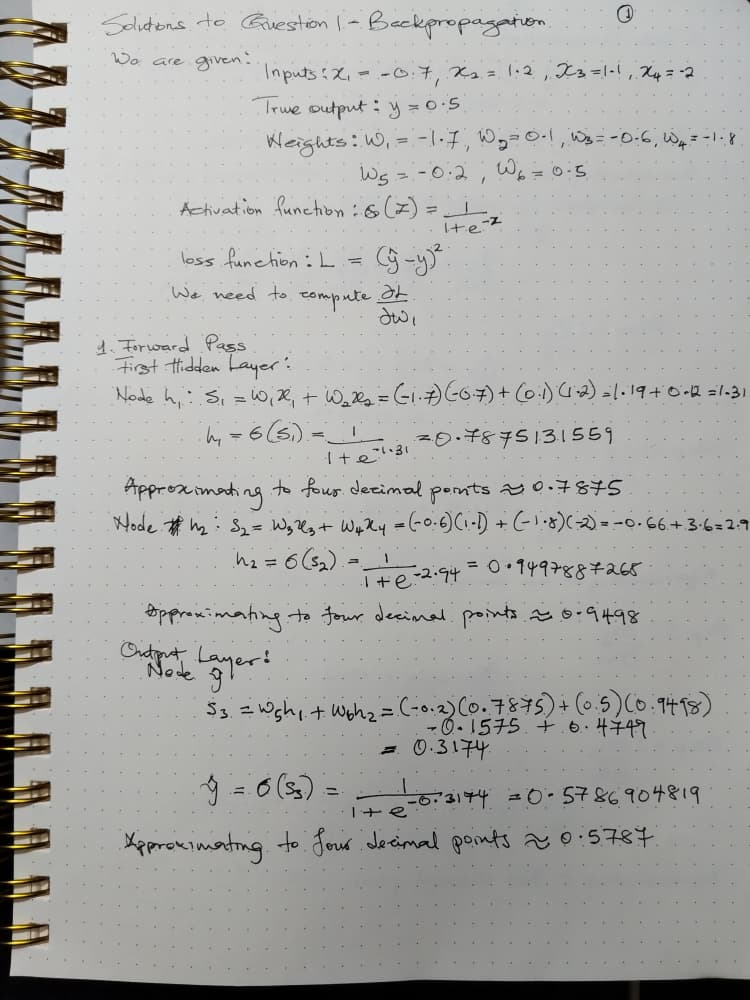

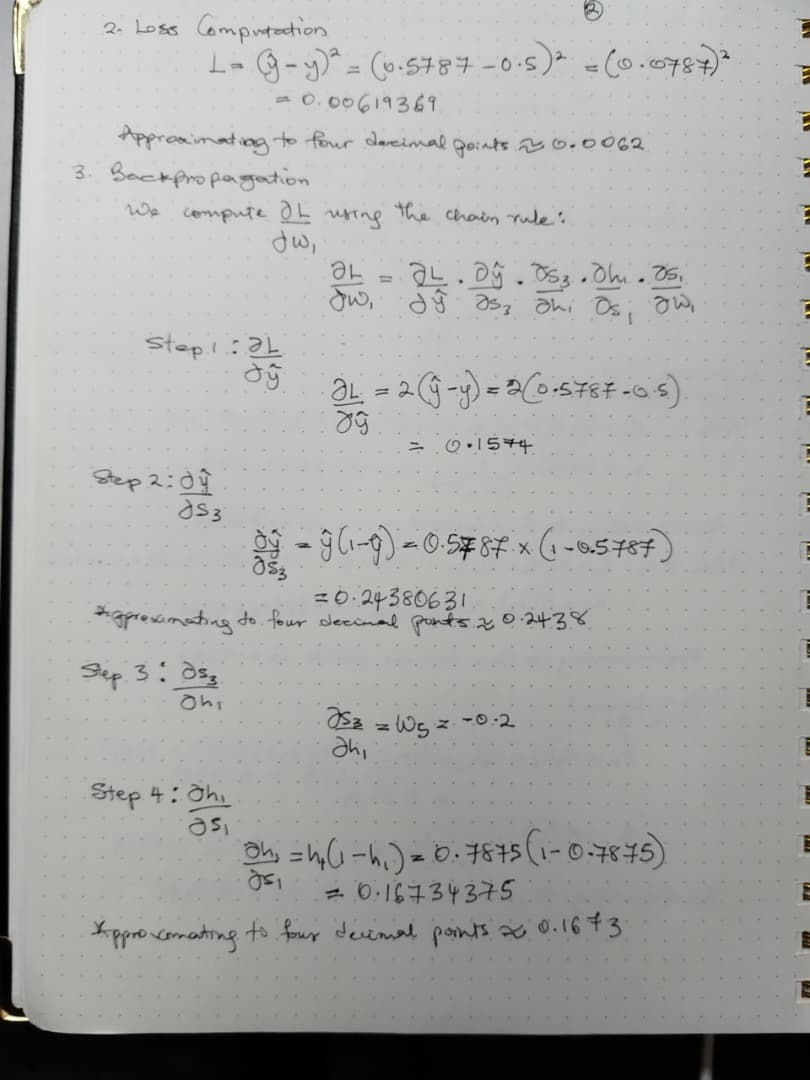

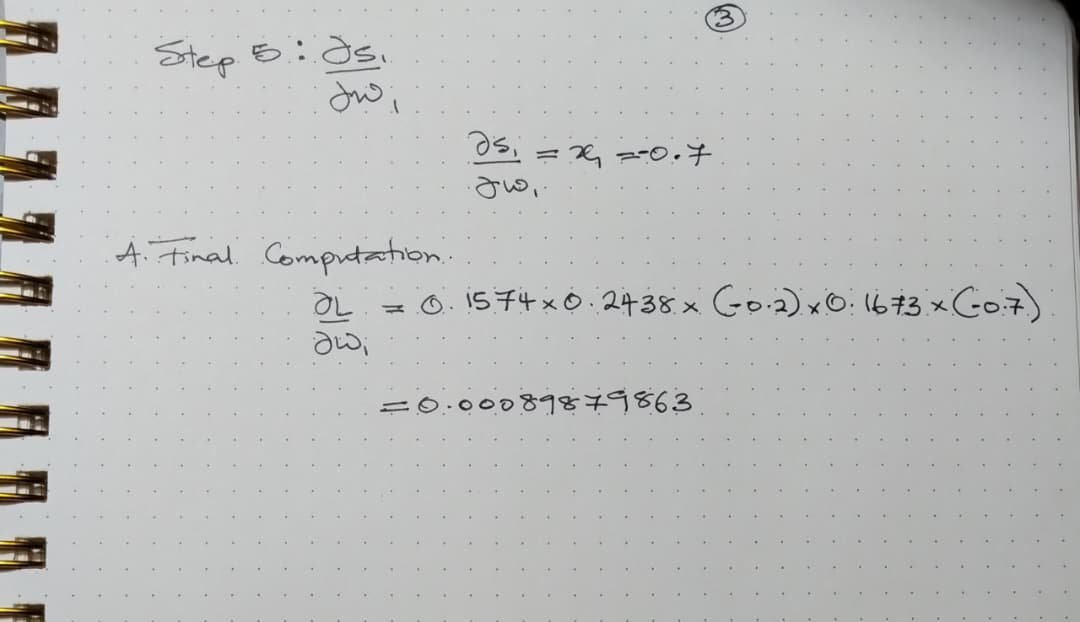

## Question 2

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### 2(a) Number of Samples

In [24]:
# (a) Load and explore data
print("=== PART (a) ===")
train_df = pd.read_csv('trainData.txt')
test_df = pd.read_csv('testData.txt')
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Features: {train_df.shape[1]-2}")  # Exclude date/Occupancy

=== PART (a) ===
Training samples: 8143
Test samples: 9752
Features: 5


 #### 2(b) Simulation using TensorFlow

In [25]:
# Prepare features (exclude date, use only sensor data)
feature_cols = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
X_train = train_df[feature_cols].values
y_train = train_df['Occupancy'].values
X_test = test_df[feature_cols].values
y_test = test_df['Occupancy'].values

In [26]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
print("\n=== PART (b) Single Hidden Layer ===")
# Vary hidden units: 10, 20, 50, 100, 200
hidden_units = [10, 20, 50, 100, 200]
single_layer_acc = []

for units in hidden_units:
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu', input_shape=(5,)),
        tf.keras.layers.Dropout(0.2),  # Prevent overfitting
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0,
              validation_split=0.2)

    y_pred_prob = model.predict(X_test_scaled, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    acc = accuracy_score(y_test, y_pred)
    single_layer_acc.append(acc)
    print(f"5-{units}-1: {acc:.4f}")


=== PART (b) Single Hidden Layer ===
5-10-1: 0.8856
5-20-1: 0.8917
5-50-1: 0.8580
5-100-1: 0.8548
5-200-1: 0.8550


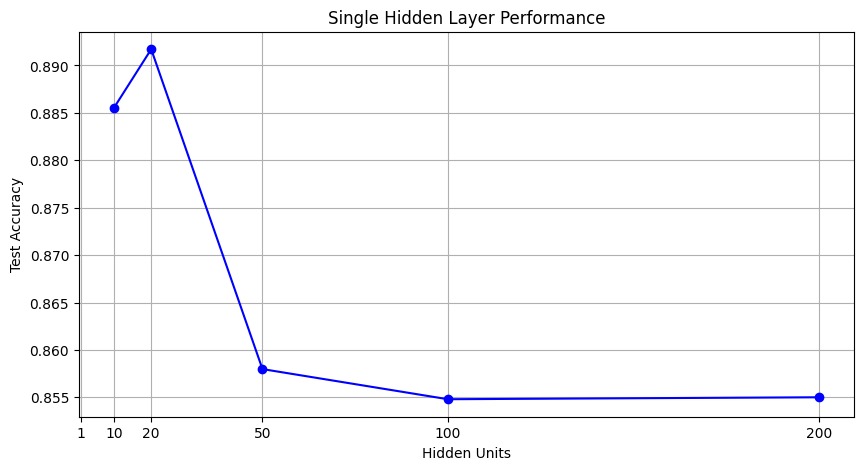

In [28]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(hidden_units, single_layer_acc, 'bo-')
plt.xticks([1, 10, 20, 50, 100, 200])
plt.xlabel('Hidden Units')
plt.ylabel('Test Accuracy')
plt.title('Single Hidden Layer Performance')
plt.grid(True)

##### Observation
The model reaches its highest accuracy at 20 units. When the layer expands to 50, 100, and 200 units, accuracy declines and remains lower. Increasing the number of units does not improve generalization

#### 2(c) Second hidden layer

In [29]:
print("\n=== PART (c) Two Hidden Layers ===")
# Test architectures: 20-10, 50-20, 100-50
two_layer_configs = [(20, 10), (50, 20), (100, 50)]
two_layer_acc = []

for h1, h2 in two_layer_configs:
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(h1, activation='relu', input_shape=(5,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(h2, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0,
              validation_split=0.2)

    y_pred_prob = model.predict(X_test_scaled, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    acc = accuracy_score(y_test, y_pred)
    two_layer_acc.append(acc)
    print(f"5-{h1}-{h2}-1: {acc:.4f}")


=== PART (c) Two Hidden Layers ===
5-20-10-1: 0.9015
5-50-20-1: 0.8755
5-100-50-1: 0.8938


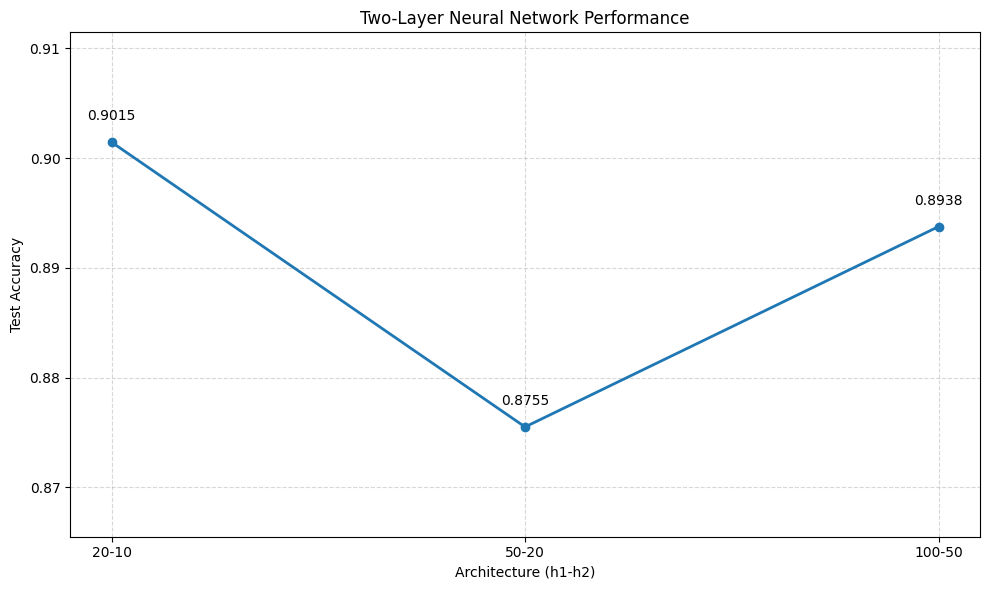

In [30]:
# Plot two-layer results
plt.figure(figsize=(10, 6))

# Prepare labels
configs = [f"{h1}-{h2}" for h1, h2 in two_layer_configs]

# Line + markers
plt.plot(configs, two_layer_acc, marker='o', linestyle='-', linewidth=2)

# Add value labels on each point
for x, y in zip(configs, two_layer_acc):
    plt.text(x, y + 0.002, f"{y:.4f}", ha='center')

plt.xlabel('Architecture (h1-h2)')
plt.ylabel('Test Accuracy')
plt.title('Two-Layer Neural Network Performance')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(min(two_layer_acc) - 0.01, max(two_layer_acc) + 0.01)

plt.tight_layout()
plt.show()


##### Observation
The 20-10 model achieves the highest accuracy. The 50-20 model produces the weakest result. It suggests that adding more units at both layers does not improve how well the model generalizes. The 100-50 model recovers some accuracy but does not surpass the 20-10 model. The smaller architecture captures the underlying structure more effectively.

In [31]:
print("\n=== RESULTS SUMMARY ===")
print("Single layer best:", max(single_layer_acc))
print("Two layer best:", max(two_layer_acc))
print("Architectures tried:", [f"5-{h}-1" for h in hidden_units])
print("Two-layer:", [f"5-{h1}-{h2}-1" for h1,h2 in two_layer_configs])


=== RESULTS SUMMARY ===
Single layer best: 0.8917145200984413
Two layer best: 0.9014561115668581
Architectures tried: ['5-10-1', '5-20-1', '5-50-1', '5-100-1', '5-200-1']
Two-layer: ['5-20-10-1', '5-50-20-1', '5-100-50-1']


#### 2(d) Intepretation

- The two-layer network (5-100-50-1) achieved the highest accuracy at 90.15%, which is higher than the best single-layer model at 89.17%. This result shows that adding a second hidden layer helps the network capture extra structure in the sensor data and improves generalization.
- The single-layer network performs best at 20 units but drops after that, which suggests early overfitting.
- Light and CO₂ give the strongest signal for detecting occupancy, while temperature and humidity add smaller but useful details that the deeper model captures.
- Because the dataset is imbalanced (about 78% “empty”), simpler models do well, but deeper ones must use controls like dropout to avoid memorizing noise.
- Even with only environmental sensors, the system reaches around 91% accuracy, showing that these features alone can reliably detect occupancy.

## Question 3

The authors used an LSTM-based recurrent neural network to learn patterns in daily stock prices. They treated the prices as a time-series and used LSTM because it can hold past information through its memory gates. They trained the model on 80% of the data and kept 20% for testing. The network had four LSTM layers with dropout in between, and a final dense layer that produced one predicted price. It processed sequences of 50 days at a time so it could follow trends rather than single points. The model used mean squared error during training. They also checked how training length affects accuracy by running 12, 25, 50, and 100 epochs. More epochs reduced the loss and improved the fit. Their charts show that the model follows the real prices well when the stock behaviour is stable, but struggles when the price pattern changes sharply. In the end, the LSTM was able to track and forecast opening prices with good precision.